# CatBoost tutorial with tasks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial_with_tasks.ipynb)

For this tutorial will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

There are 17 questions in this tutorial. Try answering all of them, this will help you to learn how to use the library.

## Libraries installation

First you need to install the libraries. To do that run:

`pip install catboost
 pip install shap
 pip install ipywidgets
 jupyter nbextension enable --py widgetsnbextension`

## Reading the data

Let's first download the dataset to folder **amazon**.

In [1]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import datasets
from catboost import *

In [2]:
train_df, test_df = catboost.datasets.amazon()
train_df.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

## Preparing your data

In [3]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_df.to_csv(os.path.join(dataset_dir, 'train.csv'), index=False)
test_df.to_csv(os.path.join(dataset_dir, 'test.csv'), index=False)

Label values extraction

In [4]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [5]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Create file describing features (for constructing Pool from file)

In [6]:
from catboost.utils import create_cd
feature_names = dict(list(enumerate(train_df.keys()[1:])))
    
create_cd(
    label=0,
    cat_features=list(range(1, train_df.shape[1])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

Now it makes sense to ananyze the dataset.
First you need to calculate how many positive and negative objects are present in the train dataset.

**Question 1:**

How many negative objects are present in the train dataset X?

In [7]:
zero_count = 0

**Question 2:**

How many positive objects are present in the train dataset X?

In [8]:
one_count = 0

In [9]:
print('Zero count = ' + str(zero_count) + ', One count = ' + str(one_count))

Zero count = 0, One count = 0


Now for every feature you need to calculate number of unique values of this feature.

**Question 3:**
    
How many unique values has feature RESOURCE?

In [10]:
unique_vals_for_RESOURCE = 0

Now we can create a Pool object. This type is used for datasets in CatBoost. You can also use numpy array or dataframe. Working with Pool class is the most efficient way in terms of memory and speed. We recommend to create Pool from file in case if you have your data on disk or from FeaturesData if you use numpy.

In [11]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)
pool3 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix. This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# Categorial features in catboost must have type str

pool4 = Pool(
    data=FeaturesData(cat_feature_data=X_prepared, cat_feature_names=list(X)),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) + '\ndataset 2:' + str(pool2.shape) + 
      '\ndataset 3:' + str(pool3.shape) + '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)
dataset 4: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Split your data into train and validation

When you will be training your model, you will have to detect overfitting and select best parameters. To do that you need to have a validation dataset.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

/home/annaveronika/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Train your model

Now we will train our first model.

In [14]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    random_seed=0,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent'
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'learning_rate': 0.1, 'random_seed': 0, 'loss_function': 'Logloss', 'iterations': 5}


## Stdout of the training

You can see in stdout values of the loss function on each iteration, or on each k-th iteration.
You can also see how much time passed since the start of the training and how much time is left.

In [15]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
    verbose=3
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.5
0:	learn: 0.3967366	test: 0.3950896	best: 0.3950896 (0)	total: 16.9ms	remaining: 237ms
3:	learn: 0.2225352	test: 0.2188028	best: 0.2188028 (3)	total: 69.5ms	remaining: 191ms
6:	learn: 0.1837186	test: 0.1736893	best: 0.1736893 (6)	total: 132ms	remaining: 151ms
9:	learn: 0.1772937	test: 0.1651104	best: 0.1651104 (9)	total: 200ms	remaining: 99.9ms
12:	learn: 0.1751288	test: 0.1625781	best: 0.1625781 (12)	total: 261ms	remaining: 40.2ms
14:	learn: 0.1742500	test: 0.1618661	best: 0.1618661 (14)	total: 301ms	remaining: 0us

bestTest = 0.1618661277
bestIteration = 14



## Random seed

If you don't specify random_seed then random seed will be set to a new value each time.
After the training has finished you can look on the value of the random seed that was set.
If you train again with this random_seed, you will get the same results.

In [16]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.5
0:	learn: 0.3967366	test: 0.3950896	best: 0.3950896 (0)	total: 18.9ms	remaining: 75.8ms
1:	learn: 0.2941275	test: 0.2925750	best: 0.2925750 (1)	total: 33.1ms	remaining: 49.7ms
2:	learn: 0.2471100	test: 0.2453087	best: 0.2453087 (2)	total: 49.1ms	remaining: 32.7ms
3:	learn: 0.2225352	test: 0.2188028	best: 0.2188028 (3)	total: 68.9ms	remaining: 17.2ms
4:	learn: 0.1994836	test: 0.1921554	best: 0.1921554 (4)	total: 91.6ms	remaining: 0us

bestTest = 0.1921554403
bestIteration = 4



In [17]:
random_seed = model.random_seed_
print('Used random seed = ' + str(random_seed))
model = CatBoostClassifier(
    iterations=5,
    random_seed=random_seed
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Used random seed = 0
Learning rate set to 0.5
0:	learn: 0.3967366	test: 0.3950896	best: 0.3950896 (0)	total: 24ms	remaining: 96.2ms
1:	learn: 0.2941275	test: 0.2925750	best: 0.2925750 (1)	total: 38.5ms	remaining: 57.7ms
2:	learn: 0.2471100	test: 0.2453087	best: 0.2453087 (2)	total: 53.9ms	remaining: 35.9ms
3:	learn: 0.2225352	test: 0.2188028	best: 0.2188028 (3)	total: 75.4ms	remaining: 18.9ms
4:	learn: 0.1994836	test: 0.1921554	best: 0.1921554 (4)	total: 99.1ms	remaining: 0us

bestTest = 0.1921554403
bestIteration = 4



Try training 10 models with parameters and calculate mean and the standart deviation of Logloss error on validation dataset.

**Question 4:**

What is the mean value of the Logloss metric on validation dataset (X_validation, y_validation) after 10 times training `CatBoostClassifier` with different random seeds in the following way:

`model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    random_seed={my_random_seed}
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)
`

In [18]:
mean = 0

**Question 5:**

What is the standard deviation of it?

In [19]:
stddev = 0

## Metrics calculation and graph plotting

When experimenting with Jupyter notebook you can see graphs of different errors during training.
To do that you need to use `plot=True` parameter.

In [20]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

**Question 6:**

What is the value of the accuracy metric value on evaluation dataset after training with parameters `iterations=50`, `random_seed=63`, `learning_rate=0.1`?

In [21]:
accuracy = 0

## Model comparison

In [22]:
model1 = CatBoostClassifier(
    learning_rate=0.5,
    iterations=50,
    random_seed=64,
    train_dir='learning_rate_0.5'
)

model2 = CatBoostClassifier(
    learning_rate=0.05,
    iterations=50,
    random_seed=64,
    train_dir='learning_rate_0.05'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=10
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=10
)

0:	learn: 0.3972443	test: 0.3958490	best: 0.3958490 (0)	total: 24.4ms	remaining: 1.19s
10:	learn: 0.1778418	test: 0.1639212	best: 0.1639212 (10)	total: 220ms	remaining: 780ms
20:	learn: 0.1729748	test: 0.1605894	best: 0.1605894 (20)	total: 433ms	remaining: 598ms
30:	learn: 0.1693509	test: 0.1596739	best: 0.1596739 (30)	total: 649ms	remaining: 398ms
40:	learn: 0.1672790	test: 0.1587722	best: 0.1586828 (38)	total: 861ms	remaining: 189ms
49:	learn: 0.1654366	test: 0.1583514	best: 0.1582410 (46)	total: 1.04s	remaining: 0us

bestTest = 0.1582410297
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 0.6550994	test: 0.6549143	best: 0.6549143 (0)	total: 30.4ms	remaining: 1.49s
10:	learn: 0.4176872	test: 0.4165343	best: 0.4165343 (10)	total: 216ms	remaining: 766ms
20:	learn: 0.3114362	test: 0.3096574	best: 0.3096574 (20)	total: 428ms	remaining: 591ms
30:	learn: 0.2585412	test: 0.2559137	best: 0.2559137 (30)	total: 633ms	remaining: 388ms
40:	learn: 0.2265871	test: 0.2228035	best:

In [23]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.05', 'learning_rate_0.5']).start()

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

**Question 7:**

Try training these models for 1000 iterations. Which model will give better best resulting Accuracy on validation dataset?
By best resulting accuracy we mean accuracy on best iteration, which might be not the last iteration.

In [24]:
best_model_name = '' # one of 'learning_rate_0.5', 'learning_rate_0.05'

## Best iteration

If a validation dataset is present then after training, the model is shrinked to a number of trees when it got best evaluation metric value on validation dataset.
By default evaluation metric is the optimized metric. But you can set evaluation metric to some other metric.
In the example below evaluation metric is `Accuracy`.

In [25]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

In [26]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 39


If you don't want the model to be shrinked, you can set `use_best_model=False`

In [27]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy',
    use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

**Question 8:**
    
What will be the number of trees in the resulting model after training with validation dataset with parameters `iterations=100`, ` learning_rate=0.5`, `eval_metric='Accuracy'` and with parameter `use_best_model=False`

In [28]:
tree_count = 0

## Cross-validation

The next functionality you need to know about is cross-validation.
For unbalanced datasets stratified cross-validation can be useful.

In [29]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

Cross-validation returns specified metric values on every iteration (or every k-th iteration, if you specify so)

In [31]:
print(cv_data[0:4])

   iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
0           0       0.527207      0.024999           0.301156   
1           1       0.610630      0.033785           0.230804   
2           2       0.766028      0.015184           0.194891   
3           3       0.802204      0.008973           0.181585   

   test-Logloss-std  train-Logloss-mean  train-Logloss-std  
0          0.003902            0.301315           0.002720  
1          0.007528            0.231994           0.002458  
2          0.008746            0.201190           0.002532  
3          0.007404            0.190605           0.002358  


Let's look on mean value and standard deviation of Logloss for cv on best iteration.

In [34]:
best_value = np.argmin(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 67.0000±0.0069 on step 67


**Question 9:**

Try running stratified cross-validation with the same parameters. What will be mean of Logloss metric on test of the stratified cross-validation on the best iteration?

In [35]:
mean_on_best_iteration = 0

**Question 10:**

Try running stratified cross-validation with the same parameters. What will be the standard deviation of Logloss metric of the stratified cross-validation on the best iteration?

In [36]:
std_on_best_iteration = 0

## Overfitting detector

A useful feature of the library is overfitting detector.
Let's try training the model with early stopping.

In [37]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

**Question 11:**

Now try training the model with the same parameters and with overfitting detector, but with `eval_metric='AUC'`
What will be the number of iterations after which the training will stop?
(Not the number of trees in the resulting model, but the number of iterations that the algorithm will perform befor training).

In [38]:
iterations_count = 0

## Snapshotting

If you train for long time, for example for several hours, you need to save snapshots.
Otherwise if your laptop or your server will reboot, you will loose all the progress.
To do that you need to specify `snapshot_file` parameter.
Try running the code below and interrupting the kernel after short time.
Then try running the same cell again.
The training will start from the iteration when the training was interrupted.
Note that all additional files are written by default into `catboost_info` directory. It can be changed using `train_dir` parameter. So the snapshot file will be there.

In [39]:
#!rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=40,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    logging_level='Verbose'
)

Learning rate set to 0.433085
0:	learn: 0.4261524	test: 0.4247549	best: 0.4247549 (0)	total: 16.6ms	remaining: 646ms
1:	learn: 0.3177889	test: 0.3161346	best: 0.3161346 (1)	total: 40.2ms	remaining: 763ms
2:	learn: 0.2659896	test: 0.2641962	best: 0.2641962 (2)	total: 51.6ms	remaining: 636ms
3:	learn: 0.2358362	test: 0.2332456	best: 0.2332456 (3)	total: 72.6ms	remaining: 654ms
4:	learn: 0.2106124	test: 0.2040855	best: 0.2040855 (4)	total: 100ms	remaining: 701ms
5:	learn: 0.1981916	test: 0.1900874	best: 0.1900874 (5)	total: 127ms	remaining: 719ms
6:	learn: 0.1921925	test: 0.1838769	best: 0.1838769 (6)	total: 156ms	remaining: 737ms
7:	learn: 0.1892536	test: 0.1806542	best: 0.1806542 (7)	total: 185ms	remaining: 739ms
8:	learn: 0.1851957	test: 0.1760177	best: 0.1760177 (8)	total: 212ms	remaining: 731ms
9:	learn: 0.1839135	test: 0.1743280	best: 0.1743280 (9)	total: 237ms	remaining: 711ms
10:	learn: 0.1829519	test: 0.1731481	best: 0.1731481 (10)	total: 264ms	remaining: 696ms
11:	learn: 0.18127

## Model predictions

There are multiple ways to do predictions.
The easiest one is to call predict or predict_proba.
You also can make predictions using C++ code. For that see [documentation](https://tech.yandex.com/catboost/doc/dg/concepts/c-plus-plus-api-docpage/).

In [40]:
print(model.predict_proba(data=X_validation))

[[0.0137 0.9863]
 [0.0149 0.9851]
 [0.0552 0.9448]
 ...
 [0.0138 0.9862]
 [0.4404 0.5596]
 [0.1125 0.8875]]


In [41]:
print(model.predict(data=X_validation))

[1. 1. 1. ... 1. 1. 1.]


For binary classification resulting value is not necessary a value in `[0,1]`. It is some numeric value. To get the probability out of this value you need to calculate sigmoid of that value.

In [42]:
raw_pred = model.predict(data=X_validation, prediction_type='RawFormulaVal')
print(raw_pred)

[4.2777 4.1892 2.8399 ... 4.2718 0.2397 2.0652]


In [43]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
probabilities = [sigmoid(x) for x in raw_pred]
print(np.array(probabilities))

[0.9863 0.9851 0.9448 ... 0.9862 0.5596 0.8875]


## Staged prediction

CatBoost also supports staged prediction - when you want to have a prediction on each object on each iteration (or on each k-th iteration). This can be used if you want to calculate the values of some custom metric using the predictions.

In [44]:
predictions_gen = model.staged_predict_proba(data=X_validation, ntree_start=0, ntree_end=5, eval_period=1)
for iteration, predictions in enumerate(predictions_gen):
    print('Iteration ' + str(iteration) + ', predictions:')
    print(predictions)

Iteration 0, predictions:
[[0.3156 0.6844]
 [0.3156 0.6844]
 [0.3156 0.6844]
 ...
 [0.3156 0.6844]
 [0.3399 0.6601]
 [0.3156 0.6844]]
Iteration 1, predictions:
[[0.2102 0.7898]
 [0.2102 0.7898]
 [0.2275 0.7725]
 ...
 [0.2102 0.7898]
 [0.2767 0.7233]
 [0.2317 0.7683]]
Iteration 2, predictions:
[[0.1506 0.8494]
 [0.1506 0.8494]
 [0.1641 0.8359]
 ...
 [0.1506 0.8494]
 [0.2032 0.7968]
 [0.1673 0.8327]]
Iteration 3, predictions:
[[0.1038 0.8962]
 [0.1038 0.8962]
 [0.1354 0.8646]
 ...
 [0.1038 0.8962]
 [0.2358 0.7642]
 [0.1382 0.8618]]
Iteration 4, predictions:
[[0.0708 0.9292]
 [0.0708 0.9292]
 [0.0981 0.9019]
 ...
 [0.0755 0.9245]
 [0.3879 0.6121]
 [0.1104 0.8896]]


## Metric evaluation on a new dataset

You can also calculate metrics directly after training.

In [45]:
metrics = model.eval_metrics(data=pool1, metrics=['Logloss','AUC'], plot=True)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

In [46]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:
[0.5593 0.6435 0.6435 0.7434 0.8481 0.8678 0.8667 0.8672 0.9005 0.9021
 0.903  0.9152 0.9233 0.929  0.934  0.9344 0.935  0.9381 0.9379 0.9374
 0.9379 0.9377 0.9392 0.9394 0.9393 0.9395 0.9393 0.9393 0.9391 0.9398
 0.9398 0.9399 0.94   0.9401 0.9403 0.9403 0.9404 0.9404 0.9406 0.9407]


**Question 12:**

Now train a model in the following way:

`
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)
`

What will be the AUC value on 550 iteration if evaluation metrics on the initial X dataset?

In [52]:
auc_value = 0

## Feature importances

Now we will learn how to understand which features are the most important ones. Let's first train the model that will not use feature combinations. To forbid feature combinations you need to use 'max_ctr_complexity=1'. This will speed up the training by a lot, but it will reduce the resulting quality. 

In [53]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

Learning rate set to 0.131488
0:	learn: 0.5443376	total: 54.6ms	remaining: 16.3s
50:	learn: 0.1661963	total: 2.72s	remaining: 13.3s
100:	learn: 0.1596890	total: 5.48s	remaining: 10.8s
150:	learn: 0.1541720	total: 8.26s	remaining: 8.15s
200:	learn: 0.1490273	total: 11.2s	remaining: 5.5s
250:	learn: 0.1453326	total: 14s	remaining: 2.74s
299:	learn: 0.1419966	total: 16.8s	remaining: 0us


Let's see which features are most important for the model without feature combinations.

In [54]:
importances = model.get_feature_importance(prettified=True)
print(importances)

      Feature Index  Importances
0            MGR_ID    24.496785
1          RESOURCE    17.490085
2     ROLE_DEPTNAME    13.851618
3  ROLE_FAMILY_DESC    11.869411
4     ROLE_ROLLUP_2     8.410186
5         ROLE_CODE     8.042388
6       ROLE_FAMILY     5.899781
7        ROLE_TITLE     5.340987
8     ROLE_ROLLUP_1     4.598758


** Question 13: **

Try training the model without the restriction of combinations, with other parameters set to the same values.
What will be top 3 most important features for this model?

In [55]:
top3 = ['ROLE_ROLLUP_1', 'ROLE_TITLE', 'ROLE_CODE'] 
# You should provide coma separater list of strings. Each string should be in single quotes. All list should be in square brackets.

## Shap values

Let's train the model one more time.

In [56]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

Learning rate set to 0.131488
0:	learn: 0.5443376	total: 57.9ms	remaining: 17.3s
50:	learn: 0.1661963	total: 2.74s	remaining: 13.4s
100:	learn: 0.1596890	total: 5.45s	remaining: 10.7s
150:	learn: 0.1541720	total: 8.16s	remaining: 8.06s
200:	learn: 0.1490273	total: 11s	remaining: 5.42s
250:	learn: 0.1453326	total: 13.7s	remaining: 2.68s
299:	learn: 0.1419966	total: 16.4s	remaining: 0us


The library provides a way to understand which features are important for a given object.
Let's take a look on the whole dataset X and analyze the influence of different features on the objects from this dataset.
We will now calculate importances for each object. After that we will visualize these importances.

In [57]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
shap_info = model.get_feature_importance(data=pool1, type='ShapValues', verbose=10000)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
print(shap_values.shape)

Processing trees...
128/300 trees processed	passed time: 17.7ms	remaining time: 23.8ms
300/300 trees processed	passed time: 42.4ms	remaining time: 0us
Processing documents...
128/32769 documents processed	passed time: 2.06ms	remaining time: 525ms
10112/32769 documents processed	passed time: 71.1ms	remaining time: 159ms
20096/32769 documents processed	passed time: 127ms	remaining time: 80.2ms
30080/32769 documents processed	passed time: 204ms	remaining time: 18.2ms
(32769, 9)


Let's look on the prediction of the model for 0-th object. The raw prediction is not the probability, to calculate probability from raw prediction you need to calculate sigmoid(raw_prediction).

In [58]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9928
Formula raw prediction = 4.9255




Sum of all shap values are equal to the resulting raw formula predition.
We can see on the graph that will be output below that there is a base value, which is equal for all the objects.
And almost all the feature have positive influence on this object. The biggest step to the right is because of the feature called 'MGR_ID'.

In [59]:
import shap
shap.initjs()
shap.force_plot(base_value=base_values[0], shap_values=shap_values[0], features=X.iloc[0])

** Question 14: **

What is the most important feature for 91-th object

In [60]:
most_important_feature = 'FEATURE_NAME'

** Question 15: **

Does it have positive or negative influence? Answer 1 if positive and -1 if negative.

In [61]:
influence_sign = 0

You can also view aggregated information about the influences on the whole dataset.

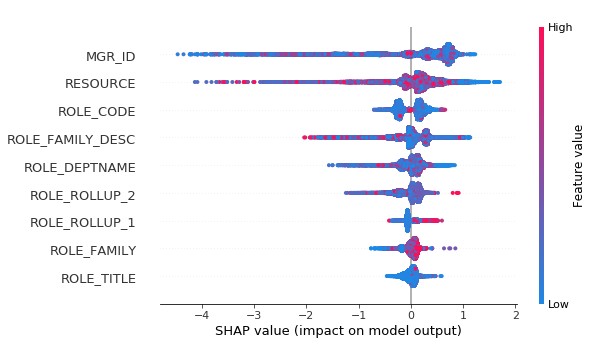

In [62]:
shap.summary_plot(shap_values, X)

From this graph you can see that values of MGR_ID and RESOURCE features have a large negative impact for many objects.
You can also see that RESOURCE has largest positive impact for many objects.

## Saving the model

You can save your model as a binary file. It is also possible to save the model as Python or C++ code.
If you save the model as a binary file you can then look on the parameters with which the model was trained, including learning_rate and random_seed that are set automatically if you don't specify them.

In [63]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')

In [64]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)
print(my_best_model.learning_rate_)

{'loss_function': u'Logloss', 'verbose': 0, 'iterations': 10, 'logging_level': u'Silent'}
0
0.5


## Hyperparameter tunning

You can tune the parameters to get better speed or better quality.
Here is the list of parameters that are important for speed and accuracy.

### Training speed

Here is the list of parameters that are important for speeding up the training.
Note that changing this parameters might decrease the quality.
1. iterations + learning rate
By default we train for 1000 iterations. You can decrease this number, but if you decrease the number of iterations you need to increase learning rate so that the process converges. We set learning rate by default dependent on number of iterations and on your dataset, so you might just use default learning rate. But if you want to tune it, you need to know - the more iterations you have, the less should be the learning rate.

2. boosting_type
By default we use Ordered boosting for smaller datasets where we want to fight overfitting. This is expensive in terms of computations. You can set boosting_type to Plain to disable this.

3. bootstrap_type
By default we sample weights from exponential distribution. It is faster to use sampling from Bernoulli distribution. To enable that use bootstrap_type='Bernoulli' + subsample={some value < 1}

4. one_hot_max_size
By default we use one-hot encoding only for categorical features with little amount of different values. For all other categorical features we calculate statistics. This is expensive, and one-hot encoding is cheep. So you can speed up the training by setting one_hot_max_size to some bigger value

5. rsm
This parameter is very important, because it speeds up the training and does not affect the quality. So you should definitely use it, but only in case if you have hundreds of features.
If you have little amount of features it's better not to use this parameter.
If you have many features then the rule is the following: you decrease rsm, for example, you set rsm=0.1. With this rsm value the training needs more iterations to converge. Usually you need about 20% more iterations. But each iteration will be 10x faster. So the resulting training time will be faster even though you will have more trees in the resulting model.

6. leaf_estimation_iterations
This parameter is responsible for calculating leaf values after you have already selected tree structure.
If you have little amount of features, for example 8 or 10 features, then this place starts to be the bottle-neck.
Default value for this parameter depends on the training objective, you can try setting it to 1 or 5, and if you have little amount of features, this might speed up the training.

7. max_ctr_complexity
By default catboost generates categorical feature combinations in a greedy way.
This is time consuming, you can disable that by setting max_ctr_complexity=1 or by allowing only combinations of 2 features by setting max_ctr_complexity=2.
This will speed up the training only if you have categorical features.

8. If you are training the model on GPU, you can try decreasing border_count. This is the number of splits considered for each feature. By default it's set to 128, but you can try setting it to 32. In many cases it will not degrade the quality of the model and will speed up the training by a lot. 

In [65]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    border_count=32)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

** Question 16: **

Try tunning the speed of the algorithm. What is the maximum speedup you could get by changing these parameters without decreasing of AUC on best iteration on eval dataset compared to AUC on best iteration after training with default parameters and random seed = 0?
The answer shoud be a number, for example 2.7 means you got 2.7 times speedup.

In [66]:
speedup = 1

### Accuracy

The parameters listed below are important to get the best quality of the model. Try changing this parameters to improve the quality of the resulting model

In [ ]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

** Question 17: **

Try tunning these parameters to make AUC on eval dataset as large as possible. What is the maximum AUC value you have reached?

In [ ]:
max_auc = 0.5